### Imports

In [380]:
import pandas as pd
import networkx as nx
from sklearn_hierarchical_classification.constants import ROOT
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.base import clone
import tqdm
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.ensemble import RandomForestClassifier

### Load data & data preprocessing

Data to create hierarchy

In [2]:
hf = "data/imclef07d.hf"

In [3]:
g = nx.DiGraph()
with open(hf, "r") as f:
    for line in f:
        v1, v2 = line.replace('\n', '').split(' ')
        g.add_edge(v1, v2)

In [4]:
[n for n,d in g.in_degree() if d==0] 
### Root is 19

['19']

In [163]:
leafs = [x for x in g.nodes() if g.out_degree(x)==0 and g.in_degree(x)==1]
leafs

['1',
 '4',
 '6',
 '8',
 '9',
 'C',
 'E',
 'F',
 '13',
 '1D',
 '1E',
 '1F',
 '20',
 '21',
 '22',
 '23',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2A',
 '2B',
 '2C',
 '2D',
 '2E']

In [5]:
tree = nx.tree_data(g, '19')

In [251]:
paths = nx.single_source_shortest_path_length(g,'19')

In [252]:
paths

{'19': 0,
 '10': 1,
 '1A': 1,
 '2': 1,
 '15': 1,
 '1B': 2,
 '16': 2,
 'B': 2,
 '3': 2,
 '12': 2,
 '1C': 2,
 '17': 2,
 'A': 2,
 '18': 2,
 '0': 2,
 '11': 2,
 '14': 2,
 '7': 2,
 '5': 2,
 'D': 2,
 '24': 2,
 '6': 3,
 'F': 3,
 '1D': 3,
 'C': 3,
 '23': 3,
 '2E': 3,
 '28': 3,
 '1': 3,
 'E': 3,
 '25': 3,
 '4': 3,
 '20': 3,
 '2D': 3,
 '21': 3,
 '27': 3,
 '26': 3,
 '2C': 3,
 '1E': 3,
 '22': 3,
 '1F': 3,
 '29': 3,
 '13': 3,
 '2B': 3,
 '2A': 3,
 '9': 3,
 '8': 3}

In [253]:
levels = {}
for key, value in paths.items():
    if value not in levels:
        levels[value] = [key]
    else:
        levels[value].append(key)

In [254]:
levels

{0: ['19'],
 1: ['10', '1A', '2', '15'],
 2: ['1B',
  '16',
  'B',
  '3',
  '12',
  '1C',
  '17',
  'A',
  '18',
  '0',
  '11',
  '14',
  '7',
  '5',
  'D',
  '24'],
 3: ['6',
  'F',
  '1D',
  'C',
  '23',
  '2E',
  '28',
  '1',
  'E',
  '25',
  '4',
  '20',
  '2D',
  '21',
  '27',
  '26',
  '2C',
  '1E',
  '22',
  '1F',
  '29',
  '13',
  '2B',
  '2A',
  '9',
  '8']}

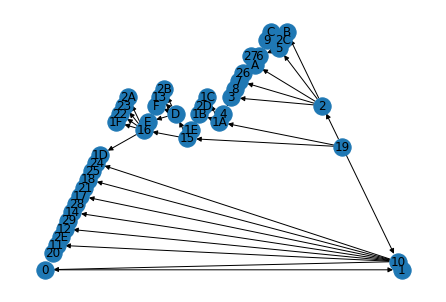

In [6]:
pos = nx.planar_layout(g)
nx.draw(g, pos, with_labels=True)

Load training data

In [7]:
train_df = pd.read_csv("data/imclef07d_train", sep=" ")
test_df = pd.read_csv("data/imclef07d_test")

In [161]:
train_df

,"15,D,2B",1:0.596529,2:-0.284171,3:0.254657,4:-0.1629,5:-0.00738333,6:0.00937143,7:-0.0245857,8:-0.132,9:-0.487257,...,72:0.210829,73:0.523171,74:0.275814,75:0.708057,76:0.174729,77:0.0073,78:0.440557,79:-0.407543,80:0.166243,Unnamed: 81
0,"15,D,2B",1:0.0251,2:0.00154286,3:0.397514,4:0.122814,5:-0.00738333,6:-0.133486,7:0.403986,8:0.0108571,9:0.0841714,...,72:0.353686,73:0.380314,74:0.275814,75:0.422343,76:0.317586,77:-0.135557,78:0.154843,79:0.592457,80:0.166243,NaN
1,"15,D,2B",1:-0.260614,2:0.00154286,3:0.540371,4:0.408529,5:-0.00738333,6:0.00937143,7:0.118271,8:0.0108571,9:0.0841714,...,72:0.210829,73:0.237457,74:0.418671,75:0.422343,76:0.174729,77:0.0073,78:0.583414,79:0.306743,80:0.0233857,NaN
2,"15,D,2B",1:-0.403471,2:-0.284171,3:0.1118,4:-0.1629,5:0.159283,6:-0.133486,7:-0.0245857,8:-0.132,9:0.227029,...,72:0.210829,73:0.237457,74:-0.295614,75:-0.149086,76:-0.3967,77:0.0073,78:0.726271,79:-0.121829,80:0.0233857,NaN
3,"15,D,2B",1:0.167957,2:-0.141314,3:0.254657,4:0.122814,5:-0.00738333,6:-0.4192,7:0.118271,8:-0.560571,9:-0.3444,...,72:-0.0748857,73:0.380314,74:0.418671,75:-0.00622857,76:-0.539557,77:-0.135557,78:0.0119857,79:-0.264686,80:-0.119471,NaN
4,"15,D,2B",1:0.167957,2:0.430114,3:-0.173914,4:-0.305757,5:-0.17405,6:-0.276343,7:0.261129,8:0.0108571,9:-0.201543,...,72:0.210829,73:0.523171,74:0.561529,75:0.279486,76:-0.3967,77:0.578729,78:0.583414,79:0.592457,80:0.166243,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,"10,11,20",1:0.453671,2:-0.284171,3:0.254657,4:0.694243,5:-0.00738333,6:-0.133486,7:-0.3103,8:-0.560571,9:0.512743,...,72:-0.217743,73:-0.191114,74:-0.438471,75:-0.149086,76:-0.539557,77:-0.135557,78:-0.273729,79:-0.407543,80:-0.119471,NaN
9995,"10,11,20",1:0.453671,2:-0.284171,3:-0.0310571,4:-0.1629,5:-0.17405,6:-0.4192,7:-0.3103,8:-0.560571,9:-0.487257,...,72:0.6394,73:-0.333971,74:-0.438471,75:-0.149086,76:-0.253843,77:0.721586,78:-0.130871,79:-0.407543,80:-0.119471,NaN
9996,"10,11,20",1:-0.117757,2:0.1444,3:0.1118,4:0.694243,5:0.159283,6:-0.4192,7:-0.3103,8:-0.560571,9:0.369886,...,72:-0.217743,73:-0.333971,74:-0.438471,75:-0.149086,76:-0.539557,77:-0.135557,78:-0.273729,79:-0.407543,80:-0.119471,NaN
9997,"10,11,20",1:0.453671,2:-0.141314,3:0.254657,4:0.408529,5:-0.00738333,6:-0.4192,7:-0.167443,8:-0.560571,9:-0.487257,...,72:-0.217743,73:-0.333971,74:-0.438471,75:-0.149086,76:-0.110986,77:-0.135557,78:-0.273729,79:-0.407543,80:-0.119471,NaN


In [9]:
def make_csv(path):
    df = pd.DataFrame()
    with open(path, "r") as f:
        for line in f:
            row = {}
            values = line.replace('\n', '').split(' ')
            row['class'] = values[0].split(',')
            for idx, value in enumerate(values[1:]):
                if len(str(value).split(":")) > 1:
                    row[idx+1] = str(value).split(":")[1]
            df = df.append(row, ignore_index=True)
    return df

In [126]:
df_train = make_csv("data/imclef07d_train")

In [162]:
df_train

,1,2,3,4,5,6,7,8,9,10,...,72,73,74,75,76,77,78,79,80,class
0,0.596529,-0.284171,0.254657,-0.1629,-0.00738333,0.00937143,-0.0245857,-0.132,-0.487257,-0.0217,...,0.210829,0.523171,0.275814,0.708057,0.174729,0.0073,0.440557,-0.407543,0.166243,"[15, D, 2B]"
1,0.0251,0.00154286,0.397514,0.122814,-0.00738333,-0.133486,0.403986,0.0108571,0.0841714,0.144967,...,0.353686,0.380314,0.275814,0.422343,0.317586,-0.135557,0.154843,0.592457,0.166243,"[15, D, 2B]"
2,-0.260614,0.00154286,0.540371,0.408529,-0.00738333,0.00937143,0.118271,0.0108571,0.0841714,0.144967,...,0.210829,0.237457,0.418671,0.422343,0.174729,0.0073,0.583414,0.306743,0.0233857,"[15, D, 2B]"
3,-0.403471,-0.284171,0.1118,-0.1629,0.159283,-0.133486,-0.0245857,-0.132,0.227029,-0.188367,...,0.210829,0.237457,-0.295614,-0.149086,-0.3967,0.0073,0.726271,-0.121829,0.0233857,"[15, D, 2B]"
4,0.167957,-0.141314,0.254657,0.122814,-0.00738333,-0.4192,0.118271,-0.560571,-0.3444,-0.188367,...,-0.0748857,0.380314,0.418671,-0.00622857,-0.539557,-0.135557,0.0119857,-0.264686,-0.119471,"[15, D, 2B]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.453671,-0.284171,0.254657,0.694243,-0.00738333,-0.133486,-0.3103,-0.560571,0.512743,-0.188367,...,-0.217743,-0.191114,-0.438471,-0.149086,-0.539557,-0.135557,-0.273729,-0.407543,-0.119471,"[10, 11, 20]"
9996,0.453671,-0.284171,-0.0310571,-0.1629,-0.17405,-0.4192,-0.3103,-0.560571,-0.487257,-0.188367,...,0.6394,-0.333971,-0.438471,-0.149086,-0.253843,0.721586,-0.130871,-0.407543,-0.119471,"[10, 11, 20]"
9997,-0.117757,0.1444,0.1118,0.694243,0.159283,-0.4192,-0.3103,-0.560571,0.369886,-0.188367,...,-0.217743,-0.333971,-0.438471,-0.149086,-0.539557,-0.135557,-0.273729,-0.407543,-0.119471,"[10, 11, 20]"
9998,0.453671,-0.141314,0.254657,0.408529,-0.00738333,-0.4192,-0.167443,-0.560571,-0.487257,-0.188367,...,-0.217743,-0.333971,-0.438471,-0.149086,-0.110986,-0.135557,-0.273729,-0.407543,-0.119471,"[10, 11, 20]"


In [119]:
df_train.to_csv("data/imclef07d_train.csv")

In [48]:
df_train = pd.read_csv("data/imclef07d_train.csv", index_col=0)

In [125]:
df_test = make_csv("data/imclef07d_test")

In [115]:
df_test

,1,2,3,4,5,6,7,8,9,10,...,72,73,74,75,76,77,78,79,80,class
0,-0.208179,-0.260721,0.531241,-0.314825,-0.0127568,-0.261573,0.290116,0.445754,-0.359273,0.177734,...,0.643283,0.374751,0.428287,0.332671,-0.245385,0.297785,0.720676,0.451008,0.433598,"[15, D, 2B]"
1,0.0775348,-0.117864,-0.0401874,-0.171968,-0.179423,0.166998,0.147259,0.445754,-0.0735586,0.177734,...,0.214712,0.231894,0.571145,0.332671,-0.388242,0.0120704,0.434962,-0.406135,0.433598,"[15, D, 2B]"
2,0.0775348,0.16785,-0.0401874,-0.029111,-0.0127568,-0.261573,0.147259,-0.411389,-0.0735586,-0.222266,...,0.357569,0.517609,0.428287,0.666004,0.183187,0.0120704,0.149247,0.165294,0.233598,"[15, D, 2B]"
3,-0.0653224,-0.117864,-0.183045,0.542318,0.15391,0.0241409,0.00440216,0.0171826,-0.216416,0.377734,...,0.0718546,0.231894,0.571145,0.499337,-0.531099,0.0120704,0.149247,-0.406135,0.0335984,"[15, D, 2B]"
4,0.648963,0.0249929,-0.0401874,-0.029111,0.320577,0.309855,-0.281312,-0.268532,-0.50213,-0.0222664,...,-0.0710026,-0.0538199,-0.00028401,-0.000662691,-0.388242,0.0120704,-0.279324,-0.406135,-0.166402,"[15, D, 2B]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.363249,-0.260721,-0.325902,0.39946,-0.179423,-0.404431,-0.281312,-0.554246,0.49787,-0.0222664,...,-0.0710026,0.517609,-0.428855,-0.000662691,-0.531099,-0.130787,-0.279324,-0.406135,-0.166402,"[10, 11, 20]"
1002,0.363249,-0.260721,-0.468759,0.685175,-0.0127568,-0.404431,-0.281312,-0.554246,-0.216416,-0.222266,...,-0.21386,-0.339534,-0.428855,-0.167329,-0.531099,-0.130787,-0.279324,-0.406135,-0.166402,"[10, 11, 20]"
1003,0.0775348,-0.260721,-0.468759,-0.171968,-0.179423,-0.404431,-0.281312,-0.554246,-0.50213,-0.222266,...,-0.21386,-0.339534,-0.428855,-0.167329,-0.531099,-0.130787,-0.279324,-0.406135,-0.166402,"[10, 11, 20]"
1004,0.220392,-0.117864,0.531241,0.113746,0.15391,-0.118716,-0.281312,-0.554246,-0.50213,-0.222266,...,-0.21386,-0.339534,-0.428855,-0.167329,-0.531099,-0.130787,-0.279324,-0.406135,-0.166402,"[10, 11, 20]"


In [116]:
df_test.to_csv("data/imclef07d_test.csv")

In [47]:
df_test = pd.read_csv("data/imclef07d_test.csv", index_col=0)

In [12]:
class_hierarchy = {}
def parse_hierarchy_to_json(G):
    node_id = None
    for key, value in G.items():
        if key == 'id':
            node_id = value
            class_hierarchy[node_id] = []
        if key == 'children':
            for node  in value:
                class_hierarchy[node_id].append(node["id"])
                parse_hierarchy_to_json(node)
    hierarchy = {k:v for k,v in class_hierarchy.items() if v}
    return hierarchy

In [13]:
hierarchy = parse_hierarchy_to_json(tree)

In [14]:
hierarchy[ROOT] = hierarchy['19'] 
hierarchy.pop('19')

['15', '1A', '2', '10']

In [15]:
hierarchy

{'15': ['16', 'D'],
 '16': ['1D', '1F', '22', '23', '2A'],
 'D': ['E', 'F', '13', '2B'],
 '1A': ['1B', '1C'],
 '1B': ['1E'],
 '1C': ['2D'],
 '2': ['3', '7', 'A', '5', 'B'],
 '3': ['4'],
 '7': ['8'],
 'A': ['26', '27'],
 '5': ['6', '9', 'C'],
 'B': ['2C'],
 '10': ['11', '12', '14', '17', '18', '0', '24'],
 '11': ['20'],
 '12': ['2E'],
 '14': ['29'],
 '17': ['28'],
 '18': ['21'],
 '0': ['1'],
 '24': ['25'],
 '<ROOT>': ['15', '1A', '2', '10']}

### Train - test

In [432]:
y_train = df_train['class']
X_train = df_train.drop(columns=['class'])

y_test = df_test['class']
X_test = df_test.drop(columns=['class'])

### Hierarchical Classification

LCN - Local classifier per node

In [433]:
clfs = {}
base_clf = DecisionTreeClassifier()
for node in g:
    if node != '19':
        clfs[node] = clone(base_clf)

In [434]:
def fit(X, Y, levels):
    for level in range(1, 4):
        labels_list = levels[level]
        print(level)
        for label in labels_list:
            y = Y[:, level-1]
            #print(y)
            #print(label)
            binary = np.array(y == label, dtype=int)
            #print(binary)
            clfs[label].fit(X, binary)
    return clfs

In [435]:
y_train = np.asarray(list(y_train))
clfs = fit(X_train, y_train, levels)
#y_pred = clf_lcn.predict(X_test)

1
2
3


In [436]:
paths_from_leaf = {}
for y in y_train:
    paths_from_leaf[y[-1]] = y

In [437]:
def predict(X):
        probs_per_clf = dict()
        labels = list()

        for label, clf in clfs.items():
            probs = clf.predict_proba(X)[:, 1]
            probs_per_clf[label] = probs
            labels.append(label)

        probs = list()
        leaves = list()
        for leaf, label in paths_from_leaf.items():
            leaves.append(leaf)
            hier_probs = list(map(probs_per_clf.get, label))
            hier_probs = np.mean(hier_probs, axis=0)
            probs.append(hier_probs)

        probs = np.stack(probs, axis=1)
        y_pred = np.argmax(probs, axis=1)
        print(y_pred)
        y_pred = list(map(leaves.__getitem__, y_pred))
        return y_pred

In [438]:
y_pred_lcn = predict(X_test)

[ 8  3 15 ... 12 25 25]


In [340]:
Y_pred= np.asarray(list(map(paths_from_leaf.get, y_pred_lcn)))

In [342]:
Y_test = np.asarray(list(y_test))[:, 2]

In [345]:
print("Classification Report:\n", classification_report(Y_test, y_pred_lcn))

Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.31      0.42        13
          13       0.33      0.20      0.25         5
          1D       0.00      0.00      0.00         1
          1E       0.82      0.75      0.78        12
          1F       0.82      0.75      0.79       198
          20       0.89      0.62      0.73        13
          21       1.00      0.25      0.40         4
          22       0.60      0.64      0.62       255
          23       0.50      0.25      0.33         8
          25       0.00      0.00      0.00         2
          26       0.47      0.41      0.44        59
          27       0.95      0.68      0.79        87
          28       0.50      0.33      0.40        15
          29       0.43      0.30      0.35        10
          2A       0.33      0.33      0.33         3
          2B       0.41      0.64      0.50       154
          2C       0.45      0.33      0.38        57
   

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LCPN - Local Classifier per Parent Node

In [440]:
y_train = df_train['class']
X_train = df_train.drop(columns=['class'])

y_test = df_test['class']
X_test = df_test.drop(columns=['class'])

In [441]:
base_estimator = make_pipeline(
    DecisionTreeClassifier()
)
clf_lcpn = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=hierarchy,
    algorithm='lcpn'
)

In [442]:
clf_lcpn.fit(X_train, y_train.apply(lambda x: x[-1]))

HierarchicalClassifier(base_estimator=Pipeline(steps=[('decisiontreeclassifier',
                                                       DecisionTreeClassifier())]),
                       class_hierarchy={'0': ['1'],
                                        '10': ['11', '12', '14', '17', '18',
                                               '0', '24'],
                                        '11': ['20'], '12': ['2E'],
                                        '14': ['29'], '15': ['16', 'D'],
                                        '16': ['1D', '1F', '22', '23', '2A'],
                                        '17': ['28'], '18': ['21'],
                                        '1A': ['1B', '1C'], '1B': ['1E'],
                                        '1C': ['2D'],
                                        '2': ['3', '7', 'A', '5', 'B'],
                                        '24': ['25'], '3': ['4'],
                                        '5': ['6', '9', 'C'], '7': ['8'],
                    

In [443]:
y_pred_lcpn = clf_lcpn.predict(X_test)

In [429]:
print("Classification Report:\n", classification_report(y_test.apply(lambda x: x[-1]), y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.23      0.24        13
          13       0.00      0.00      0.00         5
          1D       0.00      0.00      0.00         1
          1E       0.75      0.75      0.75        12
          1F       0.67      0.80      0.73       198
          20       0.70      0.54      0.61        13
          21       0.00      0.00      0.00         4
          22       0.58      0.54      0.56       255
          23       0.00      0.00      0.00         8
          25       0.50      0.50      0.50         2
          26       0.42      0.32      0.37        59
          27       0.82      0.78      0.80        87
          28       0.33      0.40      0.36        15
          29       0.17      0.20      0.18        10
          2A       0.00      0.00      0.00         3
          2B       0.57      0.45      0.50       154
          2C       0.36      0.42      0.39        57
   

In [444]:
graph = clf_lcpn.graph_

In [445]:
with multi_labeled(y_test.apply(lambda x: x[-1]), y_pred_lcpn, graph) as (y_test_, y_pred_, graph_):
    h_fbeta = h_fbeta_score(
        y_test_,
        y_pred_,
        graph_,
    )
    print("h_f1_score: ", h_fbeta)

h_f1_score:  0.6837806301050176


LCL - Local Classifier per Level

In [459]:
y_train = df_train['class']
X_train = df_train.drop(columns=['class'])

y_test = df_test['class']
X_test = df_test.drop(columns=['class'])

In [460]:
y_train = np.asarray(list(y_train))

In [461]:
clfs = []
base_clf = DecisionTreeClassifier()
for level in range(0,3):
    clfs.append(clone(base_clf))

In [462]:
def fit(X, Y):
    for level in range(Y.shape[1]):
        y = Y[:, level]
        clfs[level].fit(X, y)
    return clfs
        

def predict(X, clfs):
    prediction = []
    for clf in clfs:
        prediction.append(clf.predict(X))
    Y_pred = np.stack(prediction, axis=1)
    return Y_pred

In [463]:
clfs = fit(X_train, y_train)

In [464]:
y_pred_lcl = predict(X_test, clfs)[:,2]
Y_test = np.asarray(list(y_test))[:, 2]

In [465]:
print("Classification Report:\n", classification_report(Y_test, y_pred_lcl))

Classification Report:
               precision    recall  f1-score   support

           1       0.31      0.31      0.31        13
          13       0.00      0.00      0.00         5
          1D       0.00      0.00      0.00         1
          1E       0.57      0.67      0.62        12
          1F       0.75      0.84      0.79       198
          20       0.77      0.77      0.77        13
          21       0.50      0.25      0.33         4
          22       0.62      0.53      0.57       255
          23       0.00      0.00      0.00         8
          25       0.00      0.00      0.00         2
          26       0.43      0.39      0.41        59
          27       0.75      0.71      0.73        87
          28       0.38      0.20      0.26        15
          29       0.10      0.10      0.10        10
          2A       0.00      0.00      0.00         3
          2B       0.58      0.53      0.55       154
          2C       0.37      0.47      0.42        57
   

Big Bang Approach

In [511]:
y_train = df_train['class']
X_train = df_train.drop(columns=['class'])

y_test = df_test['class']
X_test = df_test.drop(columns=['class'])

In [512]:
clf_big_bang = make_pipeline(
            TruncatedSVD(n_components=30),
            RandomForestClassifier()
        )
mlb = MultiLabelBinarizer()
clf_big_bang.fit(X_train, mlb.fit_transform(y_train))
y_pred = clf_big_bang.predict(X_test)
y_pred_bb = mlb.inverse_transform(y_pred)

In [513]:
y_pred_bb= [t[-1] if len(t)>0 else t for t in y_pred_bb ]

Flat classification

In [504]:
y_train = df_train['class']
X_train = df_train.drop(columns=['class'])

y_test = df_test['class']
X_test = df_test.drop(columns=['class'])

In [506]:
clf_flat = DecisionTreeClassifier()
clf_flat = clf_flat.fit(X_train, y_train.apply(lambda x: x[-1]))
y_pred_flat = clf_flat.predict(X_test)
print("Classification Report:\n", classification_report(y_test.apply(lambda x: x[-1]), y_pred_flat))

Classification Report:
               precision    recall  f1-score   support

           1       0.24      0.38      0.29        13
          13       0.00      0.00      0.00         5
          1D       0.00      0.00      0.00         1
          1E       0.62      0.67      0.64        12
          1F       0.72      0.84      0.78       198
          20       0.64      0.69      0.67        13
          21       0.00      0.00      0.00         4
          22       0.60      0.50      0.55       255
          23       0.06      0.12      0.08         8
          25       0.00      0.00      0.00         2
          26       0.48      0.42      0.45        59
          27       0.77      0.71      0.74        87
          28       0.25      0.20      0.22        15
          29       0.20      0.30      0.24        10
          2A       0.00      0.00      0.00         3
          2B       0.54      0.50      0.52       154
          2C       0.38      0.44      0.41        57
   

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Experiments

In [514]:
preds = [y_pred_lcn, y_pred_lcpn, y_pred_lcl, y_pred_bb, y_pred_flat]
approach = ['lcn', 'lcpn', 'lcl', 'big_bang', 'flat']
f_scores = []
for idx, pred in enumerate(preds):
    with multi_labeled(y_test.apply(lambda x: x[-1]), pred, graph) as (y_test_, y_pred_, graph_):
        h_fbeta = h_fbeta_score(
            y_test_,
            y_pred_,
            graph_,
        )
        print(approach[idx], ": h_f1_score: ", h_fbeta)
        f_scores.append(h_fbeta)

lcn : h_f1_score:  0.7408460718094562
lcpn : h_f1_score:  0.6837806301050176
lcl : h_f1_score:  0.7256932843301035
big_bang : h_f1_score:  0.5779253112033195
flat : h_f1_score:  0.7173949160990197


Text(0.5, 1.0, 'Hierarchical F-Score')

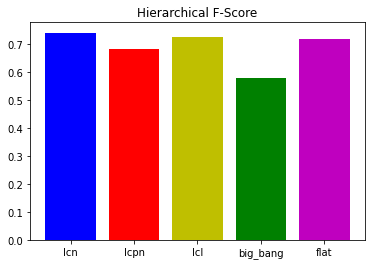

In [515]:
import matplotlib.pyplot as plt
plt.bar(approach, f_scores, color=['b','r','y','g','m'])
plt.title("Hierarchical F-Score")

### Wnioski

#### LCN
Plusy:
- Podejście jest z natury wieloetykietowe

Minusy:
- Potrzeba bardzo dużej liczby klasyfikatorów = duży koszt obliczeniowy
- Problem niekonsekwencji

Rezultaty:
- Osiągnięto najlepszy rezultat hierarchicznego F1 Score względem wszystkich testowanych podejść
- h_f1 = 0.74

#### LCPN
Plusy:
- Podejście intuicyjne
- Możliwa implementacja przy pomocy biblioteki
- Brak problemu niekonsekwencji

Minusy:
- Potrzeba bardzo dużej liczby klasyfikatorów = duży koszt obliczeniowy

Rezultaty:
- h_f1 = 0.68

#### LCL

Plusy:
- Podejście wymaga znaczenie mniej klasyfikatorów niż LCN i LCPN
- Proste w implementacji

Minusy:
- Ignorowanie relacji rodzic-dziecko
- Problem niekonsekwencji
- Na niższych węzłach dużo klas

Rezultaty:
- h_f1 = 0.73

#### Big Bang

Plusy:
- Proste w implementacji

Minusy:
- Złożoność
- Słabe wyniki na badanym zbiorze

Rezultaty:
- h_f1 = 0.58

#### Flat
Plusy:
- Podejście wymaga tylko jednego klasyfikatora
- Proste w implementacji

Minusy:
- Uproszczenie zadania - pominięcie informacji wynikających z hierarchii

Rezultaty:
- h_f1 = 0.72
- Stosunkowo dobry wynik biorąc pod uwagę nakład pracy